In [21]:
import pandas as pd

file_path = r'C:\Users\lucas\Downloads\FYM\IWSC Rolex Race.csv'
data = pd.read_csv(file_path)

data.head()

,Car,Class,Driver,Lap,Lap Time,Session Time,Flag,Location,S01,S02,S03
0,31,GTP,Pipo Derani,1,1:38.123,1:38.123,Green,Track,24.840,45.326,27.956
1,7,GTP,Felipe Nasr,1,1:38.617,1:38.617,Green,Track,25.045,45.505,27.953
2,1,GTP,Sebastien Bourdais,1,1:39.242,1:39.242,Green,Track,25.056,45.609,28.167
3,25,GTP,Connor De Phillippi,1,1:39.993,1:39.993,Green,Track,25.359,46.023,28.061
4,10,GTP,Ricky Taylor,1,1:40.897,1:40.897,Green,Track,25.577,46.126,28.321


In [22]:
from datetime import timedelta
def time_to_timedelta(time_str):
    try:
        parts = list(map(float, time_str.split(':')))
        
        if len(parts) == 2:
            minutes, seconds = parts
            hours = 0
        elif len(parts) == 3:
            hours, minutes, seconds = parts
        else:
            raise ValueError("Incorrect time format")
        
        return seconds + minutes * 60 + hours * 3600
    except ValueError as e:
        print(f"Error converting time: {e}")
        return pd.NaT 
data['Lap Time'] = data['Lap Time'].apply(time_to_timedelta)
data['Session Time'] = data['Session Time'].apply(time_to_timedelta)

data.tail()

,Car,Class,Driver,Lap,Lap Time,Session Time,Flag,Location,S01,S02,S03
36509,74,LMP2,Felipe Fraga,767,102.571,86404.187,Finish,Track,25.078,47.862,29.631
36510,52,LMP2,Tom Dillmann,767,102.766,86404.480,Finish,Track,25.380,47.731,29.655
36511,21,GTD,Miguel Molina,731,107.255,86404.521,Finish,Track,25.717,50.159,31.379
36512,8,LMP2,Scott McLaughlin,767,102.250,86405.285,Finish,Track,24.332,47.832,30.086
36513,45,GTD,Graham Doyle,643,113.832,86417.685,Finish,Track,27.702,52.615,33.515


In [23]:
gtd_gtd_pro_data = data[data['Class'].isin(['GTD', 'GTD Pro'])]

gtd_gtd_pro_data.head()

,Car,Class,Driver,Lap,Lap Time,Session Time,Flag,Location,S01,S02,S03
25,12,GTD,Aaron Telitz,1,134.482,134.482,Green,Track,27.227,50.454,32.140
26,66,GTD,Katherine Legge,1,135.051,135.051,Green,Track,26.895,50.990,32.097
27,86,GTD,Klaus Bachler,1,135.091,135.091,Green,Track,26.642,50.980,32.506
28,34,GTD,Manny Franco,1,135.201,135.201,Green,Track,27.095,50.762,31.857
31,45,GTD,Kyle Marcelli,1,136.892,136.892,Green,Track,27.370,51.551,32.618


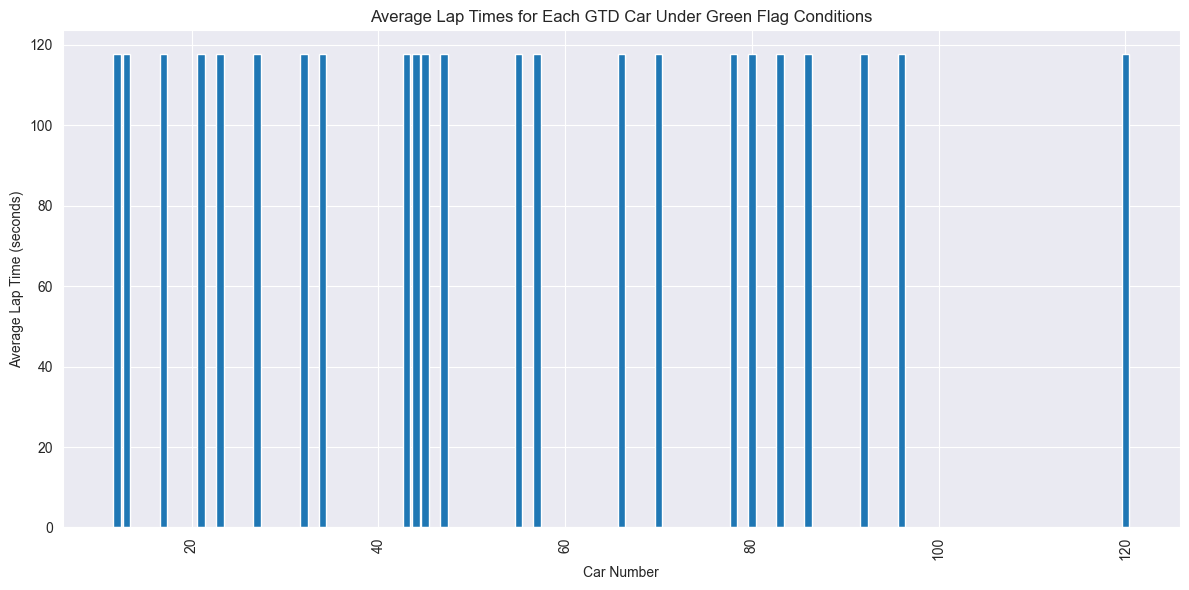

In [24]:
import matplotlib.pyplot as plt
green_flag_data = gtd_gtd_pro_data[gtd_gtd_pro_data['Flag'] == 'Green']

average_lap_times = green_flag_data.groupby('Car')['Lap Time'].mean().reset_index()

average_lap_times['Lap Time'] = average_lap_times['Lap Time'].mean()

average_lap_times['Car'] = average_lap_times['Car'].astype('category')

plt.figure(figsize=(12, 6))
bars = plt.bar(average_lap_times['Car'], average_lap_times['Lap Time'])  # Light blue color
plt.xlabel('Car Number')
plt.ylabel('Average Lap Time (seconds)')
plt.title('Average Lap Times for Each GTD Car Under Green Flag Conditions')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

In [25]:
gtd_gtd_pro_data = gtd_gtd_pro_data.dropna(subset=['Lap Time'])

gtd_gtd_pro_data['Next Lap Time'] = gtd_gtd_pro_data.groupby('Car')['Lap Time'].shift(-1)
gtd_gtd_pro_data['Pit Stop'] = (gtd_gtd_pro_data['Next Lap Time'] > gtd_gtd_pro_data['Lap Time'] + pd.Timedelta(seconds=20))

def calculate_5_lap_avg(group, index, before=True):
    if before:
        laps = group.iloc[index-5:index]
    else:
        laps = group.iloc[index+3:index+8]
    return laps['Lap Time'].mean().total_seconds() if len(laps) == 5 else None

results = []
for car_number, car_data in gtd_gtd_pro_data.groupby('Car'):
    car_data = car_data.reset_index(drop=True)
    for i, row in car_data[car_data['Pit Stop'] == True].iterrows():
        if i >= 5 and i+5 < len(car_data):
            laps_before = car_data.iloc[i-5:i]
            laps_after = car_data.iloc[i+3:i+8]
            if 'Yellow' not in laps_before['Flag'].values and 'Yellow' not in laps_after['Flag'].values:
                avg_before = calculate_5_lap_avg(car_data, i, before=True)
                avg_after = calculate_5_lap_avg(car_data, i, before=False)
                if avg_before and avg_after:
                    results.append({
                        'Car': car_number,
                        'Pit Lap': i,
                        '5 Lap Avg Before': avg_before,
                        '5 Lap Avg After': avg_after
                    })

results_df = pd.DataFrame(results)

results_df.head()


TypeError: Concatenation operation is not implemented for NumPy arrays, use np.concatenate() instead. Please do not rely on this error; it may not be given on all Python implementations.

In [ ]:
results_df = pd.DataFrame(results)

total_averages = results_df.groupby('Car').agg({
    '5 Lap Avg Before': 'mean',
    '5 Lap Avg After': 'mean'
}).reset_index()

print(total_averages)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = results_df[['5 Lap Avg Before']]
y = results_df['5 Lap Avg After']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

mse, y_pred[:10], (X_test[:10].values, y_test[:10].values)


NameError: name 'results_df' is not defined

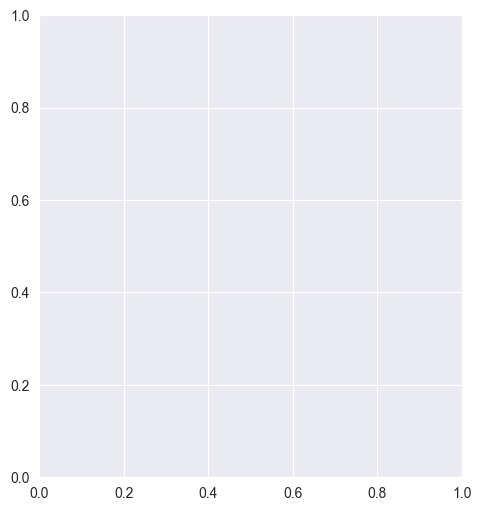

In [7]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(results_df['5 Lap Avg Before'], bins=20, color='blue', edgecolor='black')
plt.xlabel('5 Lap Avg Before (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of 5 Lap Avg Before')

plt.subplot(1, 2, 2)
plt.hist(results_df['5 Lap Avg After'], bins=20, color='green', edgecolor='black')
plt.xlabel('5 Lap Avg After (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of 5 Lap Avg After')

plt.tight_layout()
plt.show()

In [8]:
from sklearn.preprocessing import StandardScaler
Q1_before = results_df['5 Lap Avg Before'].quantile(0.25)
Q3_before = results_df['5 Lap Avg Before'].quantile(0.75)
IQR_before = Q3_before - Q1_before
lower_bound_before = Q1_before - 1.5 * IQR_before
upper_bound_before = Q3_before + 1.5 * IQR_before

Q1_after = results_df['5 Lap Avg After'].quantile(0.25)
Q3_after = results_df['5 Lap Avg After'].quantile(0.75)
IQR_after = Q3_after - Q1_after
lower_bound_after = Q1_after - 1.5 * IQR_after
upper_bound_after = Q3_after + 1.5 * IQR_after

filtered_df = results_df[
    (results_df['5 Lap Avg Before'] >= lower_bound_before) &
    (results_df['5 Lap Avg Before'] <= upper_bound_before) &
    (results_df['5 Lap Avg After'] >= lower_bound_after) &
    (results_df['5 Lap Avg After'] <= upper_bound_after)
]

X_filtered = filtered_df[['5 Lap Avg Before']]
y_filtered = filtered_df['5 Lap Avg After']

scaler = StandardScaler()
X_filtered_scaled = scaler.fit_transform(X_filtered)

X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_filtered_scaled, y_filtered, test_size=0.2, random_state=42)

model_filtered = LinearRegression()
model_filtered.fit(X_train_filtered, y_train_filtered)

y_pred_filtered = model_filtered.predict(X_test_filtered)

mse_filtered = mean_squared_error(y_test_filtered, y_pred_filtered)

print(f"Mean Squared Error: {mse_filtered}")
print(f"Predictions: {y_pred_filtered[:10]}")
print(f"Actual Values: {y_test_filtered[:10].values}")




NameError: name 'results_df' is not defined

In [ ]:
X_test_original = scaler.inverse_transform(X_test_filtered)

differences = y_test_filtered.values - y_pred_filtered

average_difference = differences.mean()

print(f"Average Difference between actual and predicted 5 Lap Avg After: {average_difference:.2f} seconds")
average_before = X_test_original.mean()

average_predicted_after = y_pred_filtered.mean()

average_difference = average_predicted_after - average_before

print(f"Average of 5 Lap Avg Before: {average_before:.2f} ")
print(f"Average of Predicted 5 Lap Avg After: {average_predicted_after:.2f} ")
print(f"Difference between averages: {average_difference:.2f} ")
# Print the size of the train and test datasets
print(f"Training set size: {X_train_filtered.shape[0]} samples")
print(f"Test set size: {X_test_filtered.shape[0]} samples")


In [ ]:
filtered_df.head()

In [26]:


# Add a column to record positions
gtd_gtd_pro_data['position'] = 0

# Function to update positions for each lap
def update_positions(df):
    for lap in df['Lap'].unique():
        lap_data = df[df['Lap'] == lap]
        for car_class in lap_data['Class'].unique():
            class_data = lap_data[lap_data['Class'] == car_class]
            class_data = class_data.sort_values(by='Session Time').reset_index(drop=True)
            for idx in range(len(class_data)):
                df.loc[(df['Car'] == class_data.loc[idx, 'Car']) & (df['Lap'] == lap), 'position'] = idx + 1
    return df

# Update the positions in the dataset
gtd_gtd_pro_data = update_positions(gtd_gtd_pro_data)
gtd_gtd_pro_data.head()

,Car,Class,Driver,Lap,Lap Time,Session Time,Flag,Location,S01,S02,S03,Next Lap Time,position
25,12,GTD,Aaron Telitz,1,134.482,134.482,Green,Track,27.227,50.454,32.140,107.681,1
26,66,GTD,Katherine Legge,1,135.051,135.051,Green,Track,26.895,50.990,32.097,108.335,2
27,86,GTD,Klaus Bachler,1,135.091,135.091,Green,Track,26.642,50.980,32.506,109.048,3
28,34,GTD,Manny Franco,1,135.201,135.201,Green,Track,27.095,50.762,31.857,108.915,4
31,45,GTD,Kyle Marcelli,1,136.892,136.892,Green,Track,27.370,51.551,32.618,109.130,5


In [27]:
race_data_sorted = gtd_gtd_pro_data.sort_values(by=['Lap', 'Session Time'])

# Calculate the gap to the car right in front
race_data_sorted['Gap to Car in Front (s)'] = race_data_sorted.groupby('Lap')['Session Time'].diff().fillna(0)

# Display the updated dataframe
race_data_sorted.shape
race_data_sorted.head(100)

,Car,Class,Driver,Lap,Lap Time,Session Time,Flag,Location,S01,S02,S03,Next Lap Time,position,Gap to Car in Front (s)
25,12,GTD,Aaron Telitz,1,134.482,134.482,Green,Track,27.227,50.454,32.140,107.681,1,0.000
26,66,GTD,Katherine Legge,1,135.051,135.051,Green,Track,26.895,50.990,32.097,108.335,2,0.569
27,86,GTD,Klaus Bachler,1,135.091,135.091,Green,Track,26.642,50.980,32.506,109.048,3,0.040
28,34,GTD,Manny Franco,1,135.201,135.201,Green,Track,27.095,50.762,31.857,108.915,4,0.110
31,45,GTD,Kyle Marcelli,1,136.892,136.892,Green,Track,27.370,51.551,32.618,109.130,5,1.691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,23,GTD,Alessio Rovera,5,107.236,567.455,Green,Track,25.440,50.461,31.335,108.661,4,1.014
267,47,GTD,Giorgio Sernagiotto,5,107.466,569.329,Green,Track,25.433,50.414,31.619,107.521,5,1.874
268,86,GTD,Klaus Bachler,5,107.839,569.438,Green,Track,25.362,50.518,31.959,108.390,6,0.109
269,70,GTD,Frederik Schandorff,5,107.272,569.443,Green,Track,25.605,50.200,31.467,107.561,7,0.005


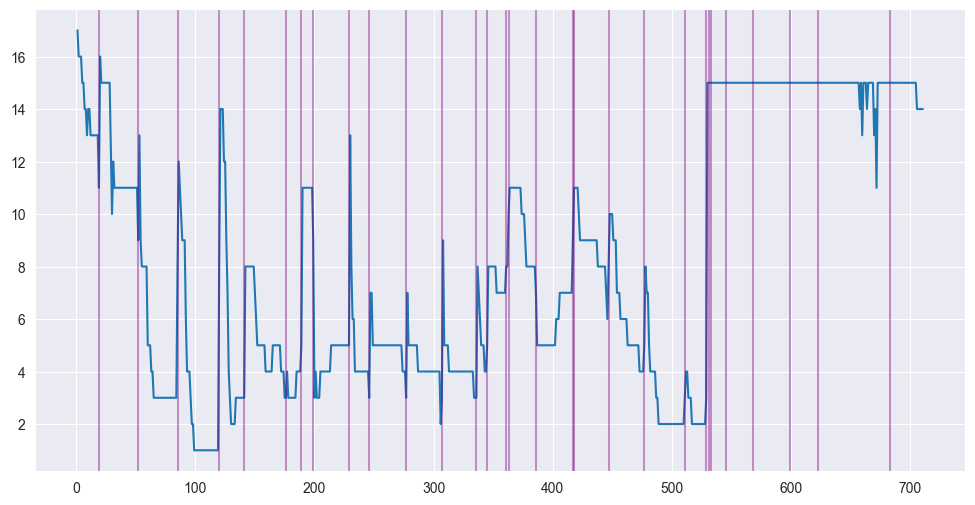

In [28]:
plt.figure(figsize=(12,6))
car_23 = race_data_sorted['Car'] == 96
plt.plot(race_data_sorted[car_23]['Lap'], race_data_sorted[car_23]['position'])
pit_laps = race_data_sorted[(race_data_sorted['Location'] == 'Pit') & car_23]['Lap']
for lap in pit_laps:
    plt.axvline(x=lap, color='purple', alpha=0.4)

Text(0.5, 1.0, 'Gap to Car in front and Position (with pits)')

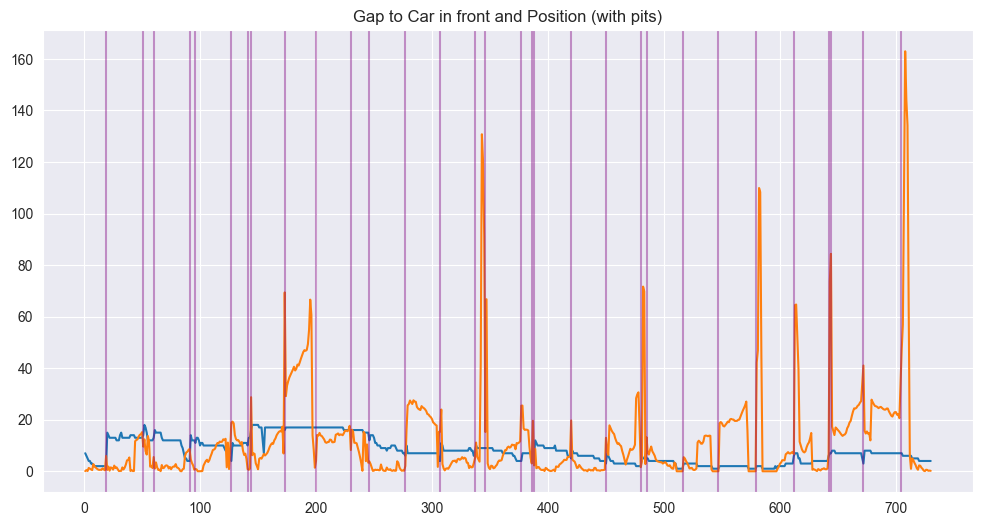

In [29]:
plt.figure(figsize=(12,6))
car_23 = race_data_sorted['Car'] == 23
plt.plot(race_data_sorted[car_23]['Lap'], race_data_sorted[car_23]['position'])
plt.plot(race_data_sorted[car_23]['Lap'], race_data_sorted[car_23]['Gap to Car in Front (s)'])
pit_laps = race_data_sorted[(race_data_sorted['Location'] == 'Pit') & car_23]['Lap']
for lap in pit_laps:
    plt.axvline(x=lap, color='purple', alpha=0.4)
plt.title('Gap to Car in front and Position (with pits)')

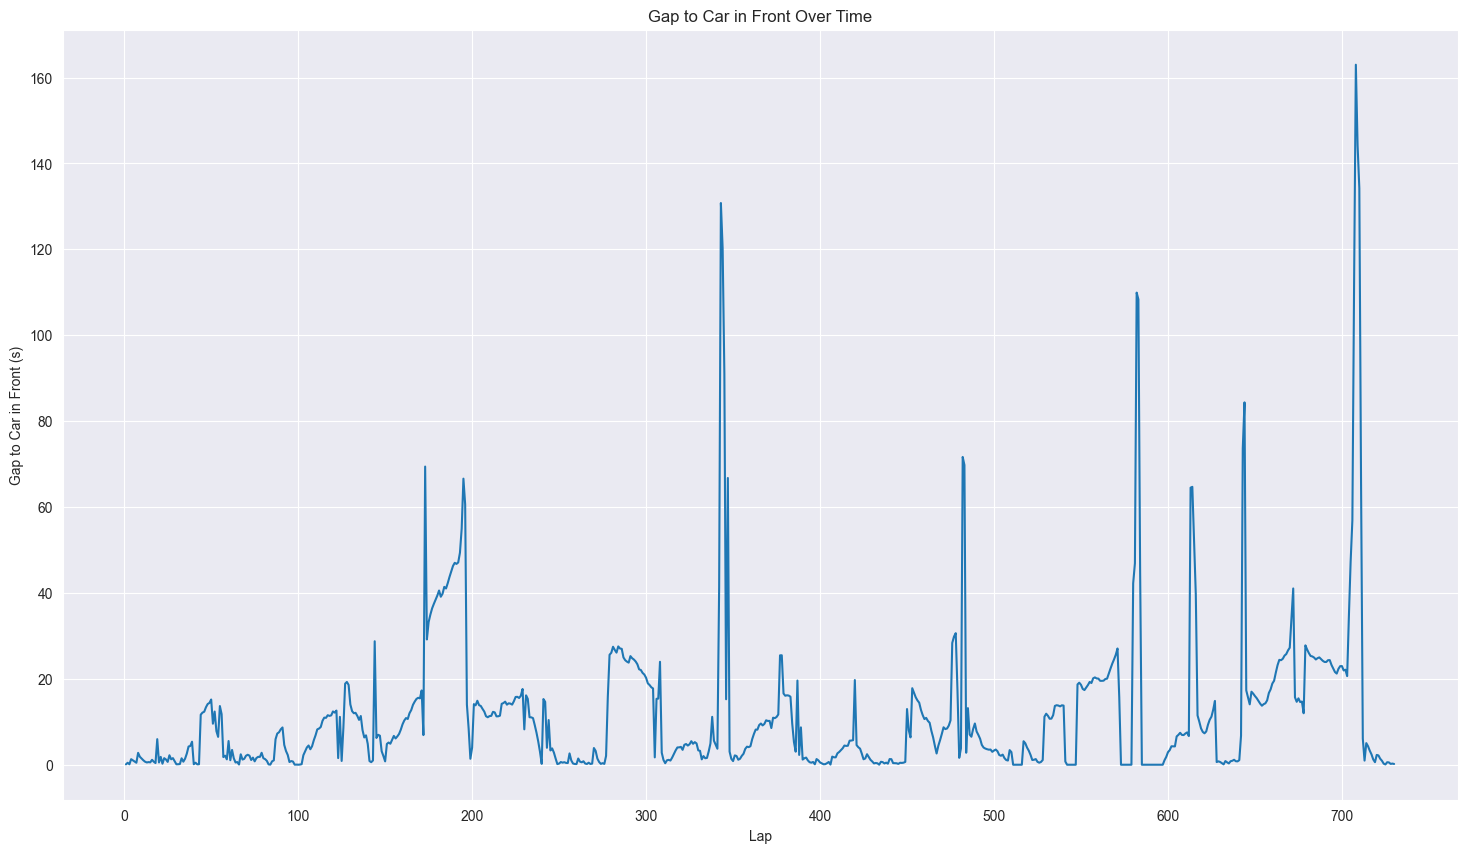

In [30]:
column_name = 'Gap to Car in Front (s)'
# Plot the data
plt.figure(figsize=(18, 10))
plt.plot( race_data_sorted[car_23]['Lap'], race_data_sorted[car_23][column_name])
plt.xlabel('Lap')
plt.ylabel('Gap to Car in Front (s)')
plt.title('Gap to Car in Front Over Time')
plt.show()

In [31]:
race_data_sorted[car_23].tail()

,Car,Class,Driver,Lap,Lap Time,Session Time,Flag,Location,S01,S02,S03,Next Lap Time,position,Gap to Car in Front (s)
36311,23,GTD,Alessio Rovera,726,108.479,85879.583,Green,Track,26.522,50.618,31.339,106.974,4,0.578
36353,23,GTD,Alessio Rovera,727,106.974,85986.557,Green,Track,25.382,50.205,31.387,107.174,4,0.538
36394,23,GTD,Alessio Rovera,728,107.174,86093.731,Green,Track,25.600,50.173,31.401,108.536,4,0.190
36437,23,GTD,Alessio Rovera,729,108.536,86202.267,Green,Track,26.134,50.508,31.894,107.071,4,0.266
36479,23,GTD,Alessio Rovera,730,107.071,86309.338,Finish,Track,25.716,50.165,31.190,NaN,4,0.176


In [32]:
avg_stint_dic = {}
def avg_stint(car):
    car_df = race_data_sorted[race_data_sorted['Car'] == car]
    pits = car_df['Location'].value_counts().get('Pit', 0)
    avg_stint_dic[car] = round(car_df['Lap'].max()/pits, 1)

for car in race_data_sorted['Car'].unique():
    avg_stint(car)
print(avg_stint_dic)

{12: 28.2, 66: 20.4, 86: 24.8, 34: 25.2, 45: 23.0, 47: 24.9, 23: 23.5, 78: 21.8, 70: 27.5, 17: 21.2, 21: 25.2, 83: 26.1, 43: 26.0, 55: 21.6, 32: 27.0, 80: 21.4, 96: 23.7, 57: 26.1, 27: 30.3, 120: 27.0, 44: 17.3, 92: 24.0, 13: 16.2}


In [70]:
race_data_sorted['Adjusted Lap'] = race_data_sorted.apply(lambda x: 0.5 if x['Flag'] == 'Yellow' else 1, axis=1)

race_data_sorted['Stint Length'] = 0

# Group by Car
grouped = race_data_sorted.groupby('Car')

# Function to calculate the stint length
def calculate_stint_length(group):
    stint_length = 0
    stint_lengths = []
    for index, row in group.iterrows():
        if row['Location'] == 'Pit':
            stint_length = 0
        elif row['Flag'] == 'Green':
            stint_length += 1
        else:
            stint_length += 0.5
        stint_lengths.append(stint_length)
    return pd.Series(stint_lengths, index=group.index)

# Group the DataFrame by 'Car' and apply the calculate_stint_length function
stint_lengths_series = race_data_sorted.groupby('Car').apply(calculate_stint_length).reset_index(level=0, drop=True)

# Add the calculated stint lengths back to the original DataFrame
race_data_sorted['Stint Length'] = stint_lengths_series

race_data_sorted['Adjusted Lap'] = race_data_sorted.groupby('Car')['Adjusted Lap'].cumsum()
# Display the last few rows of the updated DataFrame
race_data_sorted.tail(100)

C:\Users\lucas\AppData\Local\Temp\ipykernel_29700\1926774356.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stint_lengths_series = race_data_sorted.groupby('Car').apply(calculate_stint_length).reset_index(level=0, drop=True)


,Car,Class,Driver,Lap,Lap Time,Session Time,Flag,Location,S01,S02,S03,Next Lap Time,position,Gap to Car in Front (s),Adjusted Lap,Stint Length
36060,57,GTD,Daniel Morad,720,106.169,85226.056,Green,Track,25.121,49.679,31.369,106.117,1,0.000,678.0,11.0
36061,21,GTD,Miguel Molina,720,106.066,85227.360,Green,Track,25.279,49.542,31.245,106.097,2,1.304,675.5,11.0
36064,34,GTD,Albert Costa Balboa,720,106.829,85235.348,Green,Track,25.501,49.839,31.489,107.015,3,7.988,677.0,11.0
36066,23,GTD,Alessio Rovera,720,106.655,85237.630,Green,Track,25.262,50.006,31.387,106.891,4,2.282,674.5,12.0
36067,32,GTD,Kenton Koch,720,107.330,85237.710,Green,Track,25.584,49.974,31.772,108.071,5,0.080,678.0,12.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36479,23,GTD,Alessio Rovera,730,107.071,86309.338,Finish,Track,25.716,50.165,31.190,NaN,4,0.176,684.5,21.5
36481,32,GTD,Kenton Koch,730,108.215,86316.129,Finish,Track,25.980,50.297,31.938,NaN,5,6.791,688.0,22.0
36497,83,GTD,Michelle Gatting,730,108.587,86349.629,Finish,Track,25.782,50.482,32.323,NaN,6,33.500,684.5,17.5
36507,57,GTD,Daniel Morad,731,107.882,86401.790,Finish,Track,25.642,50.152,32.088,NaN,1,0.000,689.0,21.5


In [71]:
adj_avg_stint_dic = {}
def adj_avg_stint(car):
    car_df = race_data_sorted[race_data_sorted['Car'] == car]
    pits = car_df['Location'].value_counts().get('Pit', 0)
    adj_avg_stint_dic[car] = round(car_df['Adjusted Lap'].max()/pits, 1)

for car in race_data_sorted['Car'].unique():
    adj_avg_stint(car)
print(adj_avg_stint_dic)

{12: 26.6, 66: 18.8, 86: 23.2, 34: 23.7, 45: 21.5, 47: 23.4, 23: 22.1, 78: 20.6, 70: 25.9, 17: 19.6, 21: 23.7, 83: 24.4, 43: 24.4, 55: 19.8, 32: 25.5, 80: 20.2, 96: 22.3, 57: 24.6, 27: 28.0, 120: 25.3, 44: 15.8, 92: 22.4, 13: 14.8}


In [72]:
total = 0
for car in adj_avg_stint_dic:
    total += adj_avg_stint_dic[car]
avg_stint = total/len(adj_avg_stint_dic)
print(avg_stint)

22.460869565217394


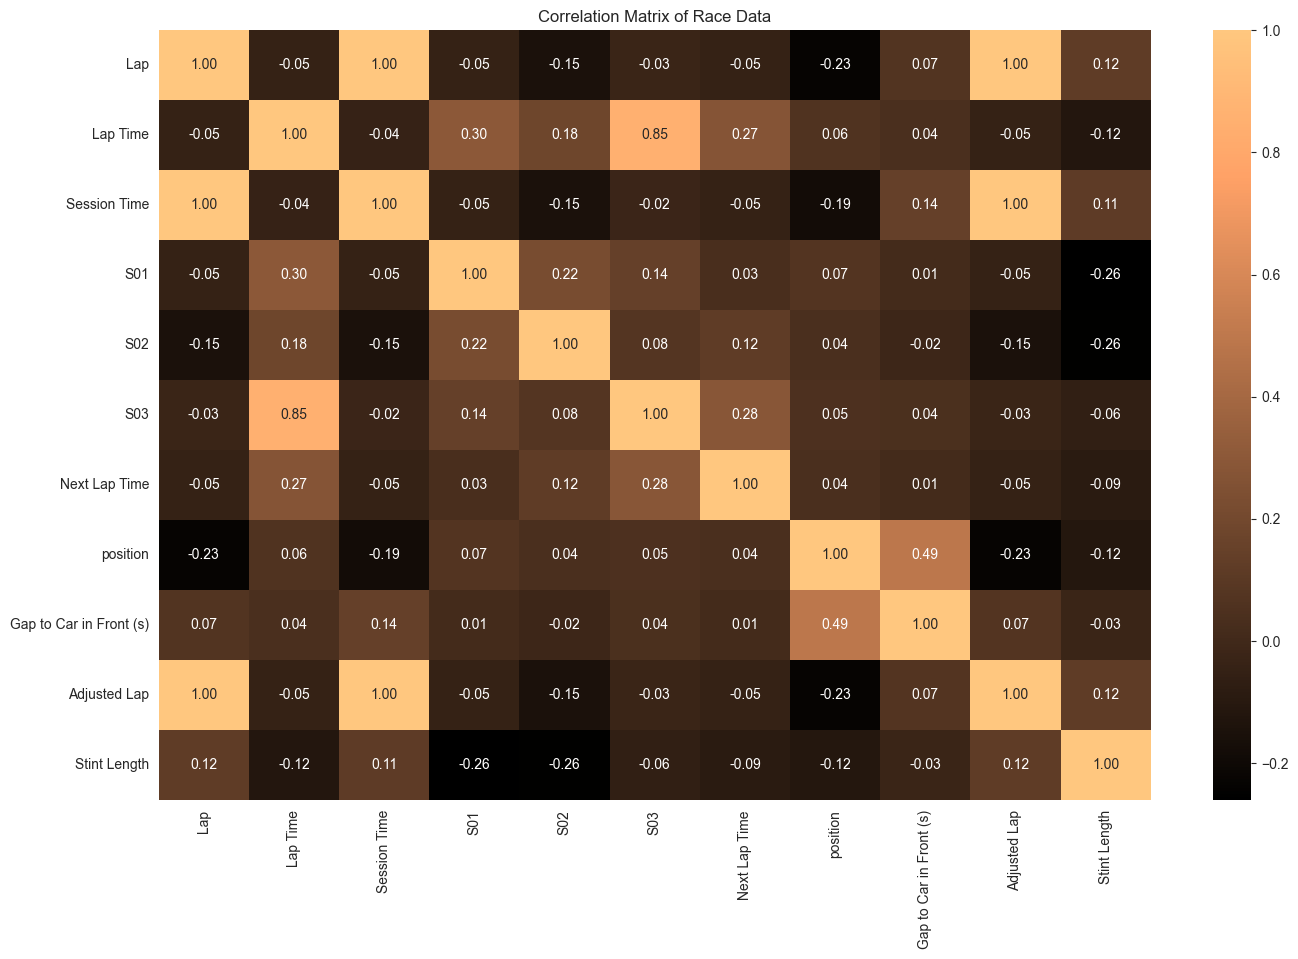

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

for_matrix = race_data_sorted.drop(columns=['Car', 'Class', 'Driver', 'Flag', 'Location'])
correlation_matrix = for_matrix.corr()

plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='copper', fmt='.2f', cbar=True)
plt.title('Correlation Matrix of Race Data')
plt.show()

In [61]:
def identify_early_pitstops(data, car_ids, stint_threshold):
    early_pitstops = []
    for car_id in car_ids:
        car_data = data[data['Car'] == car_id]
        pitstops = car_data[car_data['Location'] == 'Pit']
        
        for idx, pitstop in pitstops.iterrows():
            lap = pitstop['Lap']
            previous_lap = lap - 1
            if previous_lap in car_data['Lap'].values:
                stint_length = car_data[car_data['Lap'] == previous_lap]['Stint Length'].values[0]
                if 9 < stint_length < stint_threshold:
                    early_pitstops.append({
                        'Car': car_id,
                        'Pit Lap': lap,
                        'Stint Length': stint_length
                    })
    return pd.DataFrame(early_pitstops)

early_pits = identify_early_pitstops(race_data_sorted, race_data_sorted['Car'].unique().tolist(), avg_stint - 4)
early_pits.head(100)

,Car,Pit Lap,Stint Length
0,12,19,16.0
1,12,141,12.5
2,12,246,11.5
3,12,585,10.0
4,66,19,16.0
...,...,...,...
78,44,246,12.0
79,44,271,17.0
80,44,286,14.0
81,92,19,16.0


In [62]:
passed = 0
np = 0
for _, row in early_pits.iterrows():
    car = row['Car']
    lap = row['Pit Lap']
    pre = race_data_sorted[(race_data_sorted['Car'] == car) & (race_data_sorted['Lap'] == lap - 1)]['position'].values[0]
    post = race_data_sorted[(race_data_sorted['Car'] == car) & (race_data_sorted['Lap'] == lap + 7)]['position'].values[0]
    if pre != 1:
        front_car = race_data_sorted[(race_data_sorted['position'] == pre - 1) & (race_data_sorted['Lap'] == lap)]['Car'].values[0]
        new_pos = race_data_sorted[(race_data_sorted['Car'] == front_car) & (race_data_sorted['Lap'] == lap + 7)]['position'].values[0]
        gap = race_data_sorted[(race_data_sorted['Car'] == car) & (race_data_sorted['Lap'] == lap - 1)]['Gap to Car in Front (s)'].values[0]
        if gap < 120:
            print(f"Car: {car}, Position before early pit: {pre}, Position 4 laps later: {post}, car in front {new_pos}, prior gap {gap}")
            if post <= new_pos:
                passed += 1
            else:
                np += 1
print(passed, np)

Car: 12.0, Position before early pit: 8, Position 4 laps later: 5, car in front 7, prior gap 1.9589999999989232
Car: 12.0, Position before early pit: 5, Position 4 laps later: 3, car in front 5, prior gap 0.9839999999967404
Car: 66.0, Position before early pit: 3, Position 4 laps later: 7, car in front 13, prior gap 1.1119999999996253
Car: 66.0, Position before early pit: 13, Position 4 laps later: 12, car in front 10, prior gap 1.798000000002503
Car: 86.0, Position before early pit: 10, Position 4 laps later: 18, car in front 18, prior gap 1.6039999999998145
Car: 34.0, Position before early pit: 4, Position 4 laps later: 2, car in front 7, prior gap 2.71100000000024
Car: 34.0, Position before early pit: 16, Position 4 laps later: 14, car in front 12, prior gap 1.9240000000027067
Car: 34.0, Position before early pit: 7, Position 4 laps later: 6, car in front 9, prior gap 0.6490000000012515
Car: 45.0, Position before early pit: 16, Position 4 laps later: 20, car in front 12, prior gap 0

In [63]:
model_data = []
for _, row in early_pits.iterrows():
    car = row['Car']
    lap = row['Pit Lap']
    pre = race_data_sorted[(race_data_sorted['Car'] == car) & (race_data_sorted['Lap'] == lap - 1)]['position'].values[0]
    gap = race_data_sorted[(race_data_sorted['Car'] == car) & (race_data_sorted['Lap'] == lap - 1)]['Gap to Car in Front (s)'].values[0]
    if pre != 1:
        front_car = race_data_sorted[(race_data_sorted['position'] == pre - 1) & (race_data_sorted['Lap'] == lap)]['Car'].values[0]
        car_ahead_pos = race_data_sorted[(race_data_sorted['Car'] == front_car) & (race_data_sorted['Lap'] == lap + 7)]['position'].values[0]
    else:
        car_ahead_pos = 1
    post = race_data_sorted[(race_data_sorted['Car'] == car) & (race_data_sorted['Lap'] == lap + 7)]['position'].values[0] - car_ahead_pos
    stint_length = row['Stint Length']
    model_data.append({
        'Gap to Front': gap,
        'Position Before': pre,
        'Stint Length': stint_length,
        'Lap': lap,
        'Difference': post
    })

model_df = pd.DataFrame(model_data)
model_df.describe()

,Gap to Front,Position Before,Stint Length,Lap,Difference
count,83.000000,83.000000,83.000000,83.000000,83.000000
mean,343.153048,10.698795,13.493976,215.144578,1.710843
std,963.731554,6.314395,2.285284,175.303927,5.246439
min,0.000000,1.000000,9.500000,14.000000,-11.000000
25%,0.962000,5.000000,12.000000,19.500000,-0.500000
50%,1.960000,11.000000,13.000000,194.000000,1.000000
75%,8.724500,16.000000,16.000000,287.500000,3.000000
max,4008.865000,23.000000,17.500000,656.000000,18.000000


In [64]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [65]:
X = model_df[['Gap to Front', 'Position Before', 'Stint Length', 'Lap']]
y = model_df['Difference']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Display feature importance
feature_importance = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importance)

Mean Squared Error: 49.56650588235294
                 importance
Gap to Front       0.335232
Position Before    0.275248
Stint Length       0.265622
Lap                0.123898


In [66]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results.describe()

,Actual,Predicted
count,17.000000,17.000000
mean,0.352941,1.027059
std,5.957571,1.737062
min,-9.000000,-3.130000
25%,-4.000000,0.150000
50%,0.000000,0.980000
75%,3.000000,1.850000
max,17.000000,4.160000


In [67]:
gap_test = 10
diff_test = 4
stint_test = 4
full_model_data = []
def full_pitstop_change(df):
    for _, row in df.iterrows():
        try:
            if row['Location'] == 'Pit':
                car = row['Car'] 
                lap = row['Lap']
                gap = row['Gap to Car in Front (s)']
                pos = df[(df['Car'] == car) & (df['Lap'] == lap - 1)]['position'].values[0]
                stint = df[(df['Car'] == car) & (df['Lap'] == lap - 1)]['Stint Length'].values[0]
                if pos != 1 and lap < 710:
                    front_car = df[(df['position'] == pos - 1) & (df['Lap'] == lap)]['Car'].values[0]
                    car_ahead_pos = df[(df['Car'] == front_car) & (df['Lap'] == lap + 7)]['position'].values[0]
                else:
                    car_ahead_pos = 1
                post = race_data_sorted[(race_data_sorted['Car'] == car) & (race_data_sorted['Lap'] == lap + 7)]['position'].values[0] - car_ahead_pos  
                if gap > gap_test or abs(post) > diff_test or stint > avg_stint - stint_test:
                    raise IndexError
                full_model_data.append({
                    'Gap to Front': gap,
                    'Position Before': pos,
                    'Stint Length': stint,
                    'Lap': lap,
                    'Difference': post
                }) 
        except:
            pass
full_pitstop_change(race_data_sorted)

# Convert the list to a DataFrame
full_model_df = pd.DataFrame(full_model_data)

# Display the first few rows
# full_model_df.head()
a = 0
b = 0
for _, row in full_model_df.iterrows():
    if row['Difference'] > 0:
        b += 1
    else:
        a += 1
print(f"# of cars that came out ahead of the nearest front competitor: {a}, {'\n'}Cars that didn't: {b} {'\n'}Given a gap not bigger than {gap_test} and a difference not greater than {diff_test} {'\n'}and a stint length {stint_test} below average" )

# of cars that came out ahead of the nearest front competitor: 36, 
Cars that didn't: 34 
Given a gap not bigger than 10 and a difference not greater than 4 
and a stint length 4 below average


In [68]:
X = full_model_df[['Gap to Front', 'Position Before', 'Stint Length', 'Lap']]
y = full_model_df['Difference']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Display feature importance
feature_importance = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importance)

Mean Squared Error: 5.725957142857143
                 importance
Gap to Front       0.301664
Position Before    0.294747
Stint Length       0.229866
Lap                0.173723


In [ ]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results.describe()